## Train-Test Split
```In this exercise you will experience with an important and often neglected issue in the data scientist work - the train-test split. For a specific dataset we will examine different ways to split it and will understand the limitations and constraints we have to take when creating a good train-test split.```

```~ Ittai Haran```

In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

def maps(func, lister): # if you hate python 3 as much as I do you might want to use this
    return list(map(func, lister))

```First, load the dataset. Notice that the dataset is made out of pairs of objects, where each row has the id of each object and the features related to it. How many different objects are there?
We would like to describe the objects and the data using a specific data structure. What structure can best describe the objects and the relations between them (what two objects happen to be in the same sample)?```

In [3]:
df = pd.read_csv('data.csv').drop(columns=['Unnamed: 0'])

In [4]:
df.head()

,index_left,index_right,feature_1_left,feature_2_left,feature_3_left,feature_4_left,feature_5_left,feature_6_left,feature_7_left,feature_8_left,...,feature_92_right,feature_93_right,feature_94_right,feature_95_right,feature_96_right,feature_97_right,feature_98_right,feature_99_right,feature_100_right,target
0,926_1,407_2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10.8
1,798_1,431_2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,11.8
2,5761_1,2602_2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.6
3,6847_1,3227_2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4.4
4,9163_1,4377_2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.0


In [5]:
df.shape

(166451, 203)

```Use networkx to create a graph describing the objects and the relations between them. How many connected components the graph has? Draw a histogram of their sizes. Are there any edges between left objects and right objects? That kind of graph is called a bipartite graph. For any graph computations, networkx is your friend, and it should be very easy.```

number of connected compnents:  213


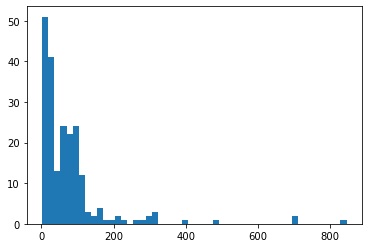

number of objects seen both as left and right objects:  0


In [14]:
list_indices = list(zip(df['index_left'], df['index_right']))
graph = nx.Graph(list_indices)

connected_components = list(nx.connected_components(graph))
print('number of connected compnents: ', str(len(connected_components)))
plt.hist(maps(len, connected_components), bins=50)
plt.show()

print('number of objects seen both as left and right objects: ', 
      str(len(set(df['index_left']).intersection(df['index_right']))))

```In order to get a baseline model we will try to have predictions using only one object from each sample. Create a dataset containing only the left objects. Drop duplicates, so every object will appear only once.```

In [17]:
left_df = df.drop(columns=['index_right']+list(map(lambda x: 'feature_'+str(x)+'_right', range(1, 101))))
left_df = left_df.drop_duplicates(subset=['index_left'])

print(left_df.shape)
print(df.shape)

(10768, 102)
(166451, 203)


```Split your data randomly with ratio 0.7-0.3. Train a simple model (a random forest, maybe?) to predict the target. Make sure your model isn't overfitted, and try to get the best score you can (on the test segment). Compare your results to a simple baseline - the mean of the target computed on the train segment.```

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(left_df.drop(columns=['target']), left_df['target'], train_size = 0.7)

In [22]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

rf_reg = RandomForestRegressor(random_state=32)

max_features = ['sqrt', 'log2']
min_samples_split = [2, 5, 10, 15, ]
min_samples_leaf = [1, 2, 4, 5, 10]
bootstrap = [True, False]
n_estimators = [40, 90, 100, 110, 120, 130, 140, 150, 200, 210, 220, 250]
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               }

random_model = RandomizedSearchCV(estimator=rf_reg, param_distributions=random_grid,
                                  n_iter=50, verbose=2, random_state=32, n_jobs=-1,
                                  return_train_score=True, cv=3)

random_model.fit(X_train, Y_train)

print('baseline mse on train: {0}'.format(mean_squared_error(Y_train,np.mean(Y_train)*np.ones(len(Y_train)))))
print('baseline mse on test: {0}'.format(mean_squared_error(Y_test,np.mean(Y_train)*np.ones(len(Y_test)))))
print('mse on train: {0}'.format(mean_squared_error(Y_train, random_model.predict(X_train))))
print('mse on test: {0}'.format(mean_squared_error(Y_test, random_model.predict(X_test))))

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.2min finished


baseline mse on train: 10.82211121221284
baseline mse on test: 10.691807073178115
mse on train: 0.20239780127155876
mse on test: 2.7820901424458344


```Repeat that process, only this use all of the sample, and not just the left object. Accordingly, you don't have to drop any duplicates. Use the naive train-test split. Did you get a good score on both train and test? why (or why not)? Do you think the score you got on the test corresponds to the "real" generalization error? why, or why not?```

In [24]:
X_train, X_test, Y_train, Y_test = train_test_split(df.drop(columns=['target']), df['target'], train_size = 0.7)

rf_reg = RandomForestRegressor(random_state=32)

max_features = ['sqrt', 'log2']
min_samples_split = [2, 5, 10, 15, ]
min_samples_leaf = [1, 2, 4, 5, 10]
bootstrap = [True, False]
n_estimators = [40, 90, 100, 110, 120, 130, 140, 150, 200, 210, 220, 250]
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               }

random_model = RandomizedSearchCV(estimator=rf_reg, param_distributions=random_grid,
                                  n_iter=50, verbose=2, random_state=32, n_jobs=-1,
                                  return_train_score=True, cv=3)

random_model.fit(X_train, Y_train)

print('baseline mse on train: {0}'.format(mean_squared_error(Y_train,np.mean(Y_train)*np.ones(len(Y_train)))))
print('baseline mse on test: {0}'.format(mean_squared_error(Y_test,np.mean(Y_train)*np.ones(len(Y_test)))))
print('mse on train: {0}'.format(mean_squared_error(Y_train, random_model.predict(X_train))))
print('mse on test: {0}'.format(mean_squared_error(Y_test, random_model.predict(X_test))))

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 40.4min finished


baseline mse on train: 9.1000140147194
baseline mse on test: 9.110322662135223
mse on train: 0.03586328117040951
mse on test: 0.4559457747153847


```We will now create a new train-test split, so that every connected component is contained either in the train segment or in the test segment. To do so, implement the following algorithm:```

```while length(train_segment)<0.7*length(data):
    choose randomly a sample s from the data (that is not in train_segment)
    add the connected component containing s to the train_segment
test_segment = data - train_segment```

In [69]:
edges_to_indexes = dict(zip(list(zip(df['index_left'], df['index_right'])), df.index))
nx.set_edge_attributes(graph, edges_to_indexes, name='edge_index')

all_connected_subgraphs = list(graph.subgraph(c) for c in nx.connected_components(graph))

train_index = []
indexes_to_choose_from = list(df.index)
while len(train_index)<=0.7*len(df):
    place = np.random.choice(indexes_to_choose_from)
    sample = df.iloc[place]

    for graph_co in all_connected_subgraphs:
        nodes_connected = graph_co.nodes()
        if sample['index_left'] in nodes_connected:
            break
 
    df_connected = df['index_left'].apply(lambda x: x in nodes_connected)
    list_indices = list(set(df_connected.index[df_connected].tolist()))
    

    train_index.extend(list_indices)
    train_index = list(set(train_index))
    indexes_to_choose_from = list(set(indexes_to_choose_from)-set(train_index)) 

test_index = indexes_to_choose_from

```Train a good model using your train segment. What is the best score you can get on your test? What is the problem with the train-test split method we used? Hint: How many connected components are there in the train segment, and how many are in the test segment? Examine also the distribution of the target, both in the train and in the test. Do they look the same?```

In [70]:
X_train, X_test, Y_train, Y_test = (df.drop(columns=['target']).iloc[train_index],
                                    df.drop(columns=['target']).iloc[test_index],
                                    df['target'].iloc[train_index],
                                    df['target'].iloc[test_index])

rf_reg = RandomForestRegressor(random_state=32)

max_features = ['sqrt', 'log2']
min_samples_split = [2, 5, 10, 15, ]
min_samples_leaf = [1, 2, 4, 5, 10]
bootstrap = [True, False]
n_estimators = [40, 90, 100, 110, 120, 130, 140, 150, 200, 210, 220, 250]
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               }

random_model = RandomizedSearchCV(estimator=rf_reg, param_distributions=random_grid,
                                  n_iter=10, verbose=2, random_state=32, n_jobs=-1,
                                  return_train_score=True, cv=3)

random_model.fit(X_train, Y_train)

print('baseline mse on train: {0}'.format(mean_squared_error(Y_train,np.mean(Y_train)*np.ones(len(Y_train)))))
print('baseline mse on test: {0}'.format(mean_squared_error(Y_test,np.mean(Y_train)*np.ones(len(Y_test)))))
print('mse on train: {0}'.format(mean_squared_error(Y_train, random_model.predict(X_train))))
print('mse on test: {0}'.format(mean_squared_error(Y_test, random_model.predict(X_test))))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 11.8min finished


baseline mse on train: 6.538061149935187
baseline mse on test: 18.225314840938328
mse on train: 0.10309847219088232
mse on test: 3.210331135135333


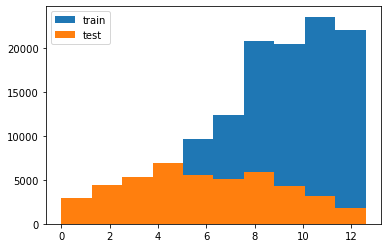

In [71]:
plt.hist(Y_train.values.reshape(-1).astype(float))
plt.hist(Y_test.values.reshape(-1).astype(float))
plt.legend(['train', 'test'])
plt.show()

```Do the train-test split again, only this time make sure you have ~0.7 of the connected components in your train segment, using a different algorithm.```

In [77]:
from sklearn.utils import shuffle

all_connected_subgraphs = shuffle(list(graph.subgraph(c) for c in nx.connected_components(graph)))
all_connected_subgraphs_lengths = np.cumsum(list(map(lambda x: len(x.edges()), all_connected_subgraphs)))
all_connected_subgraphs_lengths = np.array(all_connected_subgraphs_lengths)/float(all_connected_subgraphs_lengths[-1])
place_cut_off = np.argmax(all_connected_subgraphs_lengths>0.7)+1
print(place_cut_off)

train_index = [item for sublist in
 maps(lambda x: maps(lambda y: y['edge_index'], x.edges().values()), all_connected_subgraphs[:place_cut_off])
 for item in sublist]
test_index = list(set(list(df.index)) - set(train_index))

181


```What part of the connected components you have in your train segment this time? Try also look again at the distribution of the target in the two segments.```

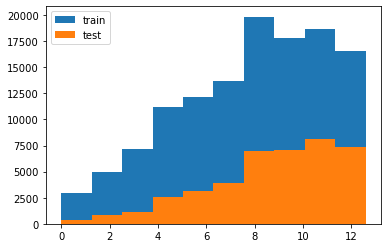

In [79]:
X_train, X_test, Y_train, Y_test = (df.drop(columns=['target']).iloc[train_index],
                                    df.drop(columns=['target']).iloc[test_index],
                                    df['target'].iloc[train_index],
                                    df['target'].iloc[test_index])

plt.hist(Y_train.values.reshape(-1).astype(float))
plt.hist(Y_test.values.reshape(-1).astype(float))
plt.legend(['train', 'test'])
plt.show()

```Train a good model using you train segment. What is the best score you can get on your test? Did you get a better score? why?```

In [80]:
rf_reg = RandomForestRegressor(random_state=32)

max_features = ['sqrt', 'log2']
min_samples_split = [2, 5, 10, 15, ]
min_samples_leaf = [1, 2, 4, 5, 10]
bootstrap = [True, False]
n_estimators = [40, 90, 100, 110, 120, 130, 140, 150, 200, 210, 220, 250]
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               }

random_model = RandomizedSearchCV(estimator=rf_reg, param_distributions=random_grid,
                                  n_iter=10, verbose=2, random_state=32, n_jobs=-1,
                                  return_train_score=True, cv=3)

random_model.fit(X_train, Y_train)

print('baseline mse on train: {0}'.format(mean_squared_error(Y_train,np.mean(Y_train)*np.ones(len(Y_train)))))
print('baseline mse on test: {0}'.format(mean_squared_error(Y_test,np.mean(Y_train)*np.ones(len(Y_test)))))
print('mse on train: {0}'.format(mean_squared_error(Y_train, random_model.predict(X_train))))
print('mse on test: {0}'.format(mean_squared_error(Y_test, random_model.predict(X_test))))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  9.4min finished


baseline mse on train: 9.464639862553485
baseline mse on test: 8.212162705837422
mse on train: 0.18217481574781696
mse on test: 2.1414154826814427


In [81]:
rf_reg = RandomForestRegressor(random_state=32)

max_features = ['sqrt', 'log2']
min_samples_split = [2, 5, 10, 15, ]
min_samples_leaf = [1, 2, 4, 5, 10]
bootstrap = [True, False]
n_estimators = [40, 90, 100, 110, 120, 130, 140, 150, 200, 210, 220, 250]
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               }

random_model = RandomizedSearchCV(estimator=rf_reg, param_distributions=random_grid,
                                  n_iter=100, verbose=2, random_state=32, n_jobs=-1,
                                  return_train_score=True, cv=3)

random_model.fit(X_train, Y_train)

print('baseline mse on train: {0}'.format(mean_squared_error(Y_train,np.mean(Y_train)*np.ones(len(Y_train)))))
print('baseline mse on test: {0}'.format(mean_squared_error(Y_test,np.mean(Y_train)*np.ones(len(Y_test)))))
print('mse on train: {0}'.format(mean_squared_error(Y_train, random_model.predict(X_train))))
print('mse on test: {0}'.format(mean_squared_error(Y_test, random_model.predict(X_test))))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 35.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 68.6min finished


baseline mse on train: 9.464639862553485
baseline mse on test: 8.212162705837422
mse on train: 0.02438372273909986
mse on test: 2.085737936907155


```Bonus: the data for this exercise was uniquely generated, using MNIST (what? how???). Can you generate a similar dataset? What parameters control this problem? Explain how it can be done.```